### Jonathan Marks
### 11/28/23

# Drug reviews sentiment analysis


# Business Problem

A health care provider is interested in efficiently extracting numeric ratings from patients' written reviews. The client already has a dataset of surveys which includes, for each sample, a patient written review, a patient numerical rating, (and other items).  However, the client will be receiving other data sets that do not contain a numerical ratings.  Only numerical ratings are able to be efficiently factored into decisions about which medicines to perscribe to patients (i.e. written reviews cannot be arthimetically averaged with efficiency) and there are multiple drug choices per condition that must be compared.  


To this end we build a model using labelled, numerically, patient reviews in order to predict numerical labels for unlabeled samples.  

# Data exploration

The data comes from Drugs.com and is accessed through UCI's website. Click [here](https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com.zip) to download data.  The data set contains over 160,000 samples.  There are very few null entries.  For this analysis 10% of the samples are analyzed (16,000) and another 16,000 are used for final model evaluation. In total, there are over 800 unique patient conditions and 3400 drugs. The key variables are the dependent variable -- patient numeric rating (10 points best) -- and the text review column, which will be used to generate independent variables. 

## Data preparation

To import and use data follow these steps:
- Go to https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com.
- Click the download button on the top right part of the page.
- Unzip the file and save only the file called 'drugsComTrain_raw.tsv', without renaming, in your repository. 

In [1]:
import pandas as pd


In [2]:
import numpy as np


In [3]:
import matplotlib.pyplot as plt

In [4]:
data = pd.read_table('./drugsComTrain_raw.tsv')

In [5]:
data.head() #show appearance of data

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


There are five potential independent variables, one target variable, and a unique id column, for total of 7 columns.

In [6]:
data.info() #Show brief overview of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   161297 non-null  int64  
 1   drugName     161297 non-null  object 
 2   condition    160398 non-null  object 
 3   review       161297 non-null  object 
 4   rating       161297 non-null  float64
 5   date         161297 non-null  object 
 6   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


There are very few missing values, only 'condition' has missing values of about 1,000, less than 1% of total sample.

It initially appears there are 885 unique condtions, but some entries may overlap (i.e. heart failure /attack and different types of diabetes)

In [7]:
len(data.condition.unique())

885

The data is fairly balanced by drug, uniformly distributed.

In [8]:


count = 0
sets = {}
for i in data.drugName:
    if sets.get(i, 0) >0:
        sets[i]+=1
    else:
        sets[i]=1


In [9]:
len(sets)

3436

It initially appears there are 3436 unique drugs, however names may overlap with eachother, and not be so distinct.

Written review metrics:

In [10]:
sm=0
for i in range(10):
    sm += len(data['review'][i])


sm/11/5

90.0

About 90 words per review, given sample of 11 and average 5 words per sentence.

Example below:


In [11]:
data.review[21]

'"I have insomnia, it&#039;s horrible. My story begins with my PCP prescribing me Prozac to help with intestinal issues, because I was desperate I tried it, I was on it for 3 weeks. Stopped because of insomnia. Then I was prescribed Ativan, it out me out, but was very addicting. I had rebound insomnia. Then after about 14 days I hardly any sleep l tried the doctor one more time. I asked him about Trazadone. He told me that was a good medication for insomnia. He put me on 25 mgs, but stated I may have to figure out what dosage is best for me. I am currently taking 100 mgs, which is on the low range of what is prescribed, 400 mgs being at the high end for insomnia. I have the dry mouth and nasel congestion. I can live with that, I sleep now, yeah..."'

Below is a historgam of the patients' ratings.

(array([21619.,  6931.,  6513.,  5012.,  8013.,  6343.,  9456., 18890.,
        27531., 50989.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

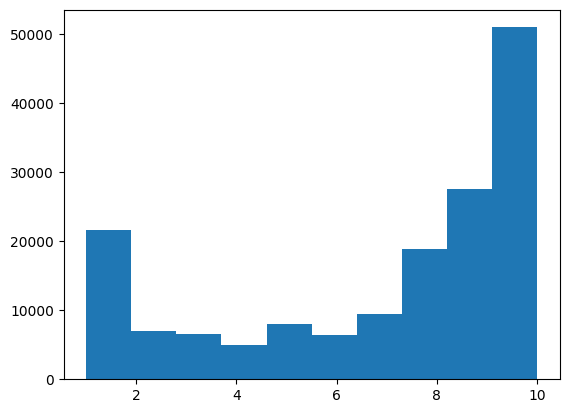

In [12]:
fig, ax =plt.subplots()

ax.hist(data['rating'])

Ratings are not normally distributed. Counts are highest at the worst and best ratings.

## Data processing - initial tokenizing

This project makes use of two different data processing methods (tf-idf or word embedding), but both methods involve tokenizing all samples individually and creating corresponding frequency distributions.  

Both methods have been used extensively for topic summary/classification tasks.  However, another property of text, besides summary, is sentiment, so these methods should be at least somewhat helpful for the task. 

For tf-idf, we divide the word usage in a given review by the word usage across the corpus of reviews in order to obtain how significant the word is to the particular view. For a positive sentiment review, positive words should be much greater in number in those reviews vs the corpus of reviews, and thus our model should be somewhat explanatory. 

For word embeddings, similar rated texts should have similar words, with similar vector representations, and so the features should be similar. This should allow the model pick up differences across different sentiment reviews. 

Initial tokenizing

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
yrat = data.rating


In [15]:
rev = data.review

In [16]:
#from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)


In [17]:
from nltk import FreqDist

First tokenizing, then creating the distribution frequencies for all invidual items. 

In [18]:
def rowFrs(reviews):
    Frds= []

    for i in data.review:
        lw= i.lower() #lowercase letters
        tkn = tokenizer.tokenize(lw) #tokenize (seperate in list form) all words in sample.
        Frd= FreqDist(tkn) #Turn tokenize list into frequency distributions (dictionaries with word counts)
        
        Frds.append(Frd)
    return Frds

In [19]:
Frqs =rowFrs(rev)


## Tf-idf model preprocessing


Expand below to include all rows, i.e. creating the frequency distribution for the corpus.  Also choose a sub-sample space for this project of 16,000 (10% of total) for better computing.  

In [20]:
com = data[0:16000] #Cut the data from 160,000 to make more manageable.

In [21]:
comb = ""
for i in com['review']:
    comb += str(i)#Combine all reviews into one string.

In [22]:
comb = comb.lower()#lowercase the string.

In [23]:
ttestw= tokenizer.tokenize(comb)#tokenize the string.

In [1]:
import nltk
from nltk.corpus import stopwords #import stopwords module
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:

stopwords_list = stopwords.words('english')

w_words_stopped = [word for word in ttestw if word not in stopwords_list] #Remove stopwords

In [26]:
w_words_stoppedC = [word for word in w_words_stopped if '039' not in word] #Remove non-sensical occurrences.

In [27]:
FD= FreqDist(w_words_stoppedC) #Create a frequency distribution for all samples (the corpus).

Getting top 200 words.

In [28]:
FD200 = FD.most_common(200)

In [29]:
FD200

[('day', 5787),
 ('side', 5259),
 ('taking', 5088),
 ('years', 4645),
 ('pain', 4511),
 ('effects', 4452),
 ('first', 4379),
 ('started', 4334),
 ('take', 4208),
 ('months', 4160),
 ('like', 4095),
 ('days', 4066),
 ('get', 4006),
 ('time', 3895),
 ('feel', 3467),
 ('would', 3236),
 ('back', 3183),
 ('one', 3034),
 ('pill', 2976),
 ('weeks', 2930),
 ('week', 2847),
 ('doctor', 2795),
 ('took', 2784),
 ('period', 2764),
 ('got', 2764),
 ('also', 2741),
 ('weight', 2694),
 ('medication', 2687),
 ('month', 2659),
 ('life', 2576),
 ('since', 2488),
 ('bad', 2426),
 ('still', 2361),
 ('much', 2294),
 ('anxiety', 2289),
 ('really', 2249),
 ('never', 2184),
 ('went', 2163),
 ('better', 2154),
 ('work', 2142),
 ('two', 2116),
 ('medicine', 2081),
 ('quot', 2062),
 ('felt', 2037),
 ('control', 2028),
 ('every', 1965),
 ('year', 1960),
 ('well', 1949),
 ('good', 1925),
 ('great', 1923),
 ('go', 1896),
 ('even', 1874),
 ('sleep', 1834),
 ('night', 1831),
 ('ago', 1785),
 ('acne', 1707),
 ('tried'

In [30]:
FD200 = dict(FD200)

See below, the top ten most common words from the corpus

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    #ax.set_ylabel("Count")
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.tick_params(axis="x", rotation=90)
    


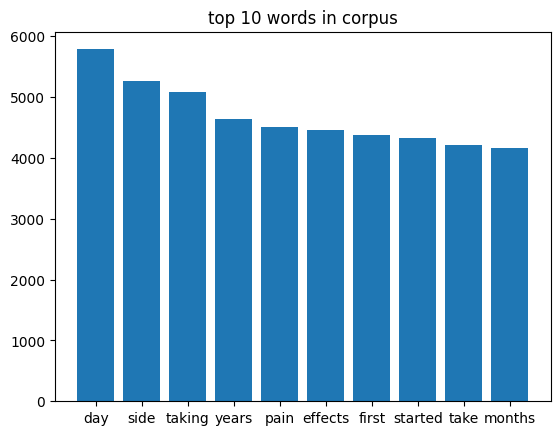

In [32]:
visualize_top_10(FD, 'top 10 words in corpus')

Creating the tf-idf matrix. This involves a computation involving frqd's of each review and the corpus as a whole. Dividing the word usage in a given review by the word usage across the corpus of reviews tells us how significant the word is to the particular view (e.g. a word with high frequency in example review but low frequency across the corpus, would yield a high number, befitting the higher importance of the word to that review). 

In [33]:

wtfids = []
for i in range(16000): #Cutting down sample size.
    tfidfs =list([]) # tf-idfs for each sample.
    for k in FD200.keys(): # For each sample compute tfidf's depending on iteration of i and k values. 
        num = Frqs[i].get(k,0)
        den = FD200[k]
        tfidf = num/den
        tfidfs.append(tfidf)
    wtfids.append(tfidfs)

Taking the first 16000 of the y-var (rating).

In [34]:
revscut= data.rating[0:16000] #Cutting sample size down.

In [35]:
yvals = np.asarray(revscut) # Converting df/ds's to arrays for computation.

In [36]:
xvals = np.asarray(wtfids)

In [37]:
x_train, x_val, y_train,  y_val = train_test_split(xvals, yvals, random_state = 2) #train test split.

In [38]:
xvals[3] #Example sample shows sparseness as most reviews have about 90 words and there are 200 words from the corpus to match with). 

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00068509, 0.        , 0.        , 0.00024038,
       0.        , 0.00073783, 0.        , 0.00025674, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00036179, 0.        ,
       0.00036483, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00045788, 0.00046232, 0.        , 0.        ,
       0.00047259, 0.        , 0.        , 0.        , 0.00098619,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00119119, 0.00121803, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00065963,
       0.        , 0.        , 0.        , 0.        , 0.     

In [39]:
indx1 =[] #finding indexes of the important featuers.


fis1 = xvals[3]
for i in range(len(fis1)):
    if fis1[i]>.001: # only include appendix if feature importance score is over .02.  This looks like natural cut-off in above array. 
        indx1.append(i)

In [40]:
featlist1 = [] #creating a list of keys, or features, (using their above index) that are most important in model.
for i in indx1:
    key = list(FD200.keys())[i]    
    featlist1.append(key)
    

In [41]:
featlist1

['birth', 'made', 'cramps', 'using', 'periods', 'happy']

Text(0.5, 1.0, 'most significant features for the random sample taken')

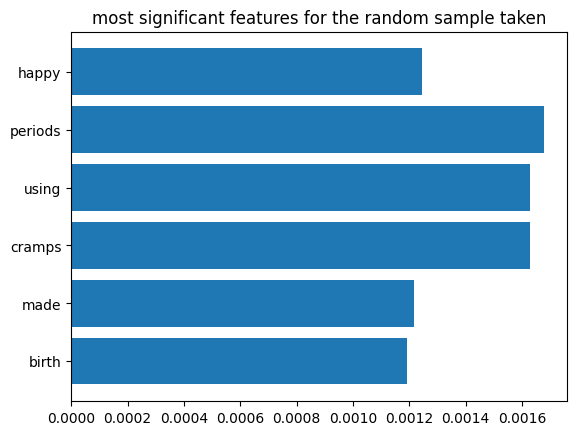

In [42]:
#### plt.figure(figsize=(25,25))

plt.barh(featlist1, fis1[indx1])
plt.title("most significant features for the random sample taken")


## word embeddings, premade, processing

To download the glove file:
- first, go to https://nlp.stanford.edu/projects/glove/.

- Then click on the glove.6B.zip link (under pretrained vectors) to download.

- Then save the file called glove.6B.50d.txt - in your repository, with the name unchanged.

This file contains 50 dimensional vectors for 6 billion words, where the 50 dimensions capture the words meaning. So mean embedding vectors will be created by averaging the vectors for each specific word of a review.  This allows us to capture some meaning from the words.

In [43]:
total_vocabulary = set(word for word in w_words_stoppedC)

In [44]:
len(total_vocabulary)

20205

In [45]:
glove = {} #importing glove vectorizer
with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary: #Cutting glove words down to only those in the corpus of documents.
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [46]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    def fit(self, X, y):
        return self
    # Gets the mean vector from all different words in the particular review.        
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

A view of how word-embeddings captures meaning: a) near synonyms (school, college) are closest (across 50 dimensions), b) two unrelated words ('drug, condition') are furthest apart, c) antonyms ('better or worse') are between the two.  

In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
synDif =mean_squared_error(glove['school'],glove['college'])#compute distance between these words.
synDif

0.09753286

In [51]:
ranDif =mean_squared_error(glove['drug'],glove['condition'])#compute distance between these words.
ranDif

0.7536165

In [52]:
oppDif= mean_squared_error(glove['better'],glove['worse'])#compute distance between these words.
oppDif

0.22213833

In [53]:
ranDif2 =mean_squared_error(glove['treatment'],glove['side'])#compute distance between these words.
ranDif2 

0.6238781

Similar words have similar representations and thus will have similar effects in the model.  Articles with similar words will have similar 50 mean features and the model will pick up these similarities.

Creating word embeddings:

In [54]:
t1 = W2vVectorizer(glove) #initializing vectorizer with premade glove 

In [55]:
t1.dimensions #showing the dimensionality per word.

50

In [56]:
t2 = t1.transform(Frqs)#transformign indivdual frequency distributions to 50 dimensional samples based on the above code (taking the mean across all words for each dimension)

In [57]:
np.shape(t2)

(161297, 50)

In [58]:
ys=data.rating[0:16000] #cutting dependent and independent variables to 16000 samplse. 
t2 =t2[0:16000]

In [59]:
x_trainW, x_valW, y_trainW,  y_valW = train_test_split(t2, ys, random_state = 2) #train-test split for word embedding processed data.

# Data modeling


In [60]:
from sklearn.tree import DecisionTreeRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor

The data modeling section describes each model iteration, including the first two baseline strategies of random guess and simple decision tree regression.  Models are evaluated based on their mse or rmse. Given that during optimizations, loss is calculated by mse, it is reasonable to use rmse as a measure of average distance between prediction and actual. Rmses can be considered as, the average, ratings points off of the actual ratings, for all ratings.

The first set of models computed use the tf-idf for feature engineering, while the second set of models use word-embedding for feature engineering. Tree regressions and linear models are used. 

### Random guess (by mean) yields an rmse of 3.27.

In [62]:
data.rating.mean()

6.994376832799122

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
data['aver_rat']=7

In [65]:
mean_squared_error(data.rating, data['aver_rat'])

10.708103684507462

In [66]:
10.7**.5

3.271085446759225

### Try a baseline regression tree, a simple model with low depth, and using tf-idf features. 

In [67]:
regrtr1 = DecisionTreeRegressor(max_depth = 3) #instantiate tree regressor.


In [68]:
regrtr1.fit(x_train, y_train)#fit to training data

DecisionTreeRegressor(max_depth=3)

In [69]:
prds1 = regrtr1.predict(x_train)#predict on training data

In [70]:
mean_squared_error(y_train, prds1)#find mse of predictions

10.02306910442066

In [71]:
rmse = mean_squared_error(y_train, prds1)**.5 #find rmse of predictions
rmse

3.165923104628516

In [72]:
regrtr1.feature_importances_ # Find importance of word features to prediction.  Words are sparsely important.

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.29430621,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02852756, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02779525, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
indx =[] #finding indexes of the important featuers.

fis = regrtr1.feature_importances_
for i in range(len(fis)):
    if fis[i]>.02: # only include appendix if feature importance score is over .02.  This looks like natural cut-off in above array. 
        indx.append(i)

In [74]:
featlist = [] #creating a list of keys, or features, (using their above index) that are most important in model.
for i in indx:
    key = list(FD200.keys())[i]    
    featlist.append(key)
    

In [75]:
featlist

['life', 'good', 'acne', 'worse', 'best', 'worst']

Text(0.5, 1.0, 'most significant features')

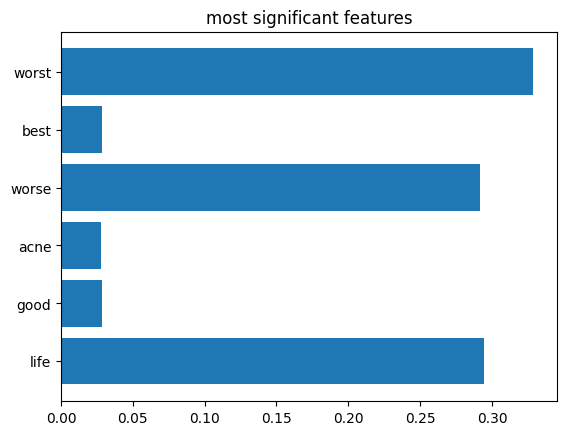

In [76]:
#### plt.figure(figsize=(25,25))

plt.barh(featlist, regrtr1.feature_importances_[indx])
plt.title("most significant features")


General insights can be gathered by looking at most significant features.  All of them seem very obviously/directly linked to sentiment (e.g., worse, good), but 'acne' is less obvious as a particular condition/effect which is very important to the sentiment rating. 

In [77]:
prds1val = regrtr1.predict(x_val) #predict on validation data with model.

In [78]:
mean_squared_error(y_val, prds1val)#find mse of predictions

10.286036787132614

In [79]:
rmseBT = mean_squared_error(y_val, prds1val)**.5
rmse

3.165923104628516

Barely any gain over guessing strategy (3.20 vs 3.27 rmses) .  Not much overfitting based on similar results on validation. Try trees with greater depths/complexity to reduce underfitting:

### Use GSCV to find better models

In [80]:
from sklearn.model_selection import GridSearchCV

In [81]:
clf = DecisionTreeRegressor() #instantiate classifier for gridsearch 

param_grid = { #allow params to make the tree more complex than prior model
    'max_depth': [1, 2, 5, 10],
    'min_samples_split': [1, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=3) #instantiate grid search tree



In [82]:
gs_tree.fit(x_train, y_train)#fit grid search tree to train data.


C:\Users\jmark\anaconda3\envs\dash-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jmark\anaconda3\envs\dash-env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jmark\anaconda3\envs\dash-env\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\jmark\anaconda3\envs\dash-env\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constrai

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 2, 5, 10],
                         'min_samples_split': [1, 5, 10, 20]})

In [83]:

gs_tree.best_params_ # show the params of the best fitting(and chosen) model.

{'max_depth': 10, 'min_samples_split': 20}

In [84]:
gspr = gs_tree.predict(x_train)# predict based on train data.

In [85]:
mean_squared_error(y_train, gspr)

8.33946596992895

In [86]:
rmse = mean_squared_error(y_train,  gspr)**.5
rmse

2.8878133544135

In [87]:
prdsgsval = gs_tree.predict(x_val)

In [88]:
mean_squared_error(y_val, prdsgsval)

10.096867733603268

In [89]:
rmseGS = mean_squared_error(y_val, prdsgsval)**.5
rmseGS

3.177556881253783

Using grid-search CV, we get only slight improvement from base tree model(3.17 v 3.21).

Running a linear regression model to try another conventional approach (particurly because this is a regression (not classification) problem.):

In [90]:
from sklearn import linear_model
lreg = linear_model.LinearRegression() #instantiating





In [91]:
lreg.fit(x_train, y_train)

LinearRegression()

In [92]:
predsL = lreg.predict(x_train)

In [93]:
mean_squared_error(y_train, predsL)

8.026101620957657

In [94]:
rmse = mean_squared_error(y_train, predsL)**.5
rmse

2.8330375255117355

In [95]:
valpredsL = lreg.predict(x_val)

In [96]:
mean_squared_error(y_val, valpredsL)

8.447988838136448

In [97]:
rmseLR = mean_squared_error(y_val, valpredsL)**.5
rmseLR

2.9065424198068137

Linear regression is more accurate than the baseline tree regressions (2.9 vs 3.27). Not a lot, if any, overfitting, likely  (2.83 rmse training and validation 2.90)

Try random forest regressor that may be able to boost accuracy further (lower rsme) due to its more complex nature than the regular tree regression.

In [98]:
rfr = RandomForestRegressor(max_samples = 100)#instantiating regressor


In [99]:
rfr.fit(x_train, y_train)

RandomForestRegressor(max_samples=100)

In [100]:
prds5 = rfr.predict(x_train)

In [101]:
mean_squared_error(y_train, prds5)
                   

9.821869194270834

In [102]:
rmse = mean_squared_error(y_train, prds5)**.5
rmse

3.1339861509379445

In [103]:
prds5val = rfr.predict(x_val)

In [104]:
mean_squared_error(y_val, prds5val)
                   

10.29612075642361

In [105]:
rmseRF = mean_squared_error(y_val, prds5val)**.5
rmseRF

3.208756886462982

Linear regression continues to perform better, with a val rmse below 3.

## Word-embeddings models

In [106]:
reglW = linear_model.LinearRegression()#instantiating





In [107]:
reglW.fit(x_trainW, y_trainW)#fit on training

LinearRegression()

In [108]:
predsW = reglW.predict(x_trainW)#predict on training

In [109]:
mean_squared_error(y_trainW, predsW)

9.188112658063222

In [110]:
rmse = mean_squared_error(y_trainW, predsW)**.5
rmse

3.0311899739315615

In [111]:
predsW = reglW.predict(x_valW)

In [112]:
mean_squared_error(y_valW, predsW)

9.624382876373005

In [113]:
rmseWl = mean_squared_error(y_valW, predsW)**.5
rmseWl

3.1023189514253695

Linear regression model with embeddings does not do much better than the guessing strategy or the baseline tree regressor. Its 3.10 is comparable to guessings 3.27 and baseline 3.17.

Try tree regression (with word-embeddings):

In [114]:
from sklearn.tree import DecisionTreeRegressor

In [115]:
regrtrw = DecisionTreeRegressor(max_depth = 3)


In [116]:
regrtrw.fit(x_trainW, y_trainW)

DecisionTreeRegressor(max_depth=3)

In [117]:
prds3w = regrtrw.predict(x_trainW)

In [118]:
mean_squared_error(y_trainW, prds3w)

9.896609843709873

In [119]:
rmse = mean_squared_error(y_trainW, prds3w)**.5
rmse

3.1458877671827192

In [120]:
prdsvalW = regrtrw.predict(x_valW)

In [121]:
mean_squared_error(y_valW, prdsvalW)

10.358814265862508

In [122]:
rmseWt = mean_squared_error(y_valW, prdsvalW)**.5
rmseWt

3.2185111877796087

Word embedding with tree performs only slightly better than guessing and similar to baseline strategy. Linear regression  (TF-IDF) model still performing best, the only model with  rmse's less than 3.0.

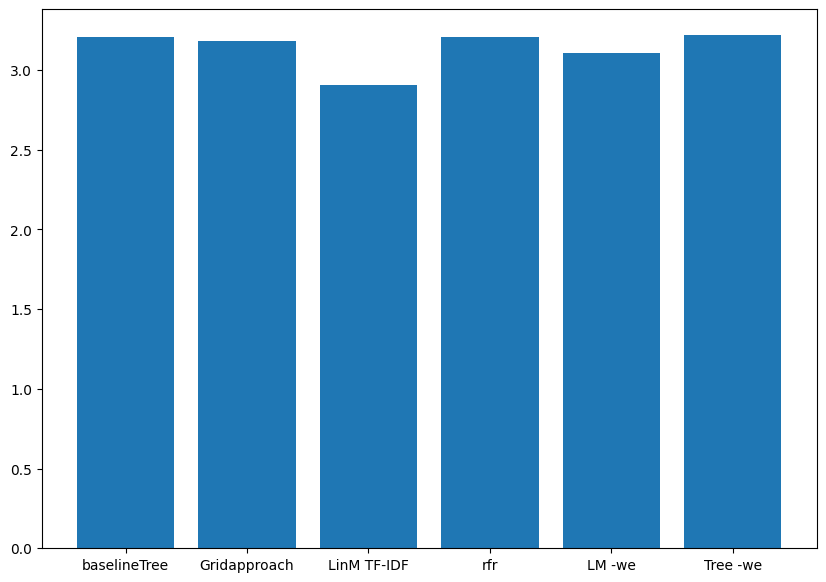

In [123]:
fig, ax = plt.subplots(figsize = (10,7))
plt.bar(['baselineTree', 'Gridapproach','LinM TF-IDF', 'rfr', 'LM -we','Tree -we'], [rmseBT, rmseGS, rmseLR, rmseRF, rmseWl, rmseWt])
plt.title= "validation Rmse's"

The linear regression using tf-idf vectorization produces the best results.  The model has the lowest rmse, meaning it produces the lowest errors and has the higher accuracy in its predictions. 

 ### Evaluate the linear regression model on unseen data. 

In [124]:
# getting fd for second 16000 samples of data.
FrqsE = Frqs[16000:32000]

Conducting tf-idf vectorization on the evaluation data

In [125]:

wtfids = []
for i in range(16000):#Cutting down sample size.
    tfidfs =list([])# tf-idfs for each sample.
    for k in FD200.keys():# For each sample compute tfidf's depending on iteration of i and k values.
        num = FrqsE[i].get(k,0)
        den = FD200[k]
        tfidf = num/den
        tfidfs.append(tfidf)
    wtfids.append(tfidfs)

Taking the second 16000 of the y-var (rating).

In [126]:
revscut= data.rating[16000:32000]

In [127]:
yvals = np.asarray(revscut)

In [128]:
xvals = np.asarray(wtfids)

In [129]:
Epreds = lreg.predict(xvals)

In [130]:
mean_squared_error(yvals, Epreds)

8.293821007749033

In [131]:
rmse = mean_squared_error(yvals, Epreds)**.5
rmse

2.879899478757728

The linear model with tf-idf continues to perform better than the other models with a rmse of 2.88.  It performs similar on unseen data, demonstrating its strength. 

# Results/conclusions

- Deploy linear regression (TF-IDF) for ‘rating extraction’ from written review, if efficiency reasons dictates that it should be used.  Given the rmse is not very different between the guessing strategy, tested models and chosen models, the results of the model should not be taken blindly. When the stakeholder accumulates written patient reviews without accompanying numerical drug ratings, the stakeholder should use this model to calculate a numeric review so that the drugs can be compared by patient evaluation.  


- Gather general insights on how patients find/rate drugs (i.e. key factors).

    - " acne, doctor, love, worse" etc. 
    -  Words like  "acne" and "doctor" and can provide us with insight into how a patient will rate the drug that may not be obvious. These insights should be useful generally and particularly to prescription choices.


- Future work
    
    - Create own word embeddings using the whole dataset instead of using Glove. 
    - Combine the tf-idf and word embedding models.
    - Use the “meta-data” as features. (i.e. the drug evaluated)


- Limitations

    - Given the rmse is not very different between the guessing strategy, tested models and chosen models, the results of the model should not be taken blindly.
    - There is material difference between the chosen model's prediction and the actual ratings
    - There may be less clarity when using nlp techniques in understanding what the model (and coefficients) mean. 

# Repository structure

- Notebook
- [README](https://github.com/jmarksk/DrugReviewAnalysis/blob/main/README.md)
- [Presentation](https://github.com/jmarksk/DrugReviewAnalysis/blob/main/Presentation.pdf)
- [data](https://github.com/jmarksk/DrugReviewAnalysis/blob/main/drugsComTrain_raw.tsv)
- [CodingEnvt](https://github.com/jmarksk/DrugReviewAnalysis/blob/main/CodingEnvt.txt)

# Addendum

### Using sklearn's tfidf vectorizer object. 

In [132]:
com = data[0:12000]# Have to reduce to 12000 because doesn't go through the split.

In [133]:
com['review1'] = com['review'].map(lambda x: x.lower())

C:\Users\jmark\AppData\Local\Temp\ipykernel_38044\3594319355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com['review1'] = com['review'].map(lambda x: x.lower())


In [134]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [135]:
com['review1'] = remove_stopwords(com['review1'])

C:\Users\jmark\AppData\Local\Temp\ipykernel_38044\1008984540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com['review1'] = remove_stopwords(com['review1'])


In [136]:
type(com['review1'])

pandas.core.series.Series

In [137]:

# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=200)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(com['review1'])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,039,10,about,acne,after,again,ago,all,almost,also,...,without,work,worked,works,worse,would,year,years,you,your
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.051996,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
2,0.091713,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.11615,0.000000,0.0,0.000000,0.000000,0.0
3,0.053478,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.104106,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
4,0.240994,0.0,0.093930,0.000000,0.000000,0.135141,0.000000,0.096606,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.099312,0.228176,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.127421,0.0,0.099328,0.156184,0.093503,0.142907,0.140094,0.102158,0.0,0.124027,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
11996,0.000000,0.0,0.000000,0.000000,0.111618,0.170593,0.000000,0.121949,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
11997,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0
11998,0.063784,0.0,0.099441,0.000000,0.000000,0.000000,0.000000,0.102274,0.0,0.000000,...,0.0,0.134143,0.144475,0.000000,0.00000,0.119259,0.0,0.210279,0.000000,0.0


In [138]:
regrtr1c = DecisionTreeRegressor(max_depth = 3)


In [139]:
np.shape(y_train)

(12000,)

In [140]:
regrtr1c.fit(X_train_vectorized, y_train)

DecisionTreeRegressor(max_depth=3)

In [141]:
prds1c = regrtr1c.predict(X_train_vectorized)

In [142]:
mean_squared_error(y_train, prds1c)

10.59625800588887

In [143]:
rmse

2.879899478757728

In [144]:
prds1cval = regrtr1c.predict(x_val)

In [145]:
mean_squared_error(y_val, prds1cval)

10.884150462753505

In [146]:
rmse = mean_squared_error(y_val, prds1cval)**.5
rmse

3.299113587428221

Using scikit's tf-idf vectorizer, with tree regression, the rmse's are subtantially the same to custom vectorizer with baseline tree/random guessing strategy. This is as expected. 